In [ ]:
# Install required packages
!pip install -q matplotlib opencv-python scikit-image plotly torch torchvision

In [ ]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from skimage import measure
import plotly.graph_objects as go
from google.colab import files

In [ ]:
#Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving Screenshot 2025-04-16 103626.png to Screenshot 2025-04-16 103626.png


In [ ]:
#Load and preprocess the X-ray image
def load_xray(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    return img

img = load_xray(image_path)

In [ ]:
#Simulate TB region using a heatmap
def generate_fake_tb_heatmap(img):
    heatmap = np.zeros_like(img)
    h, w = img.shape
    heatmap[h//4:h//2, w//3:2*w//3] = 255  # Simulated TB region
    return heatmap

heatmap = generate_fake_tb_heatmap(img)

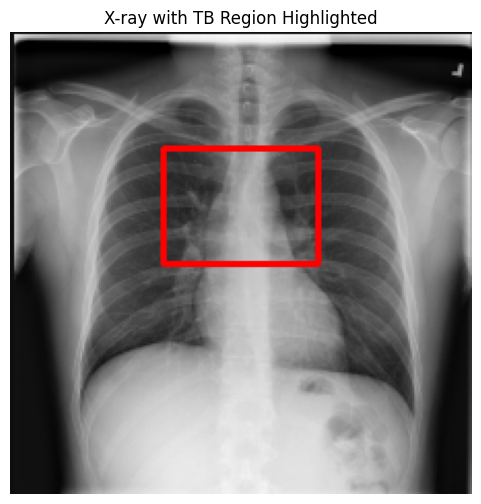

In [ ]:
#Show 2D X-ray image with bounding box
def show_tb_box_on_xray(img, heatmap):
    # Threshold heatmap to binary
    thresh = cv2.threshold(heatmap, 200, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert to BGR for color drawing
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw boxes
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Show image
    plt.figure(figsize=(6, 6))
    plt.title("X-ray with TB Region Highlighted")
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

show_tb_box_on_xray(img, heatmap)

In [ ]:
# Simulate 3D volume and plot
def generate_3d_volume(img, heatmap):
    volume = np.stack([img for _ in range(30)], axis=0)
    heatmap_volume = np.stack([heatmap for _ in range(30)], axis=0)
    return volume, heatmap_volume

def plot_3d(volume, heatmap_volume):
    verts, faces, _, _ = measure.marching_cubes(volume, level=50)
    tb_mask = heatmap_volume > 200

    fig = go.Figure(data=[
        go.Mesh3d(
            x=verts[:, 0], y=verts[:, 1], z=verts[:, 2],
            color='lightblue',
            opacity=0.3,
            alphahull=0,
        )
    ])

    # TB region as bounding box
    tb_coords = np.argwhere(tb_mask)
    if tb_coords.size > 0:
        zmin, ymin, xmin = tb_coords.min(axis=0)
        zmax, ymax, xmax = tb_coords.max(axis=0)
        fig.add_trace(go.Scatter3d(
            x=[xmin, xmax, xmax, xmin, xmin, xmax, xmax, xmin],
            y=[ymin, ymin, ymax, ymax, ymin, ymin, ymax, ymax],
            z=[zmin, zmin, zmin, zmin, zmax, zmax, zmax, zmax],
            mode='lines',
            line=dict(color='red', width=5),
            name='TB Area'
        ))

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ), title="Simulated 3D Lung with TB Highlight")
    fig.show()

# Uncomment if you want 3D plot as well
volume, heatmap_volume = generate_3d_volume(img, heatmap)
plot_3d(volume, heatmap_volume)